Label(value='Ready.')

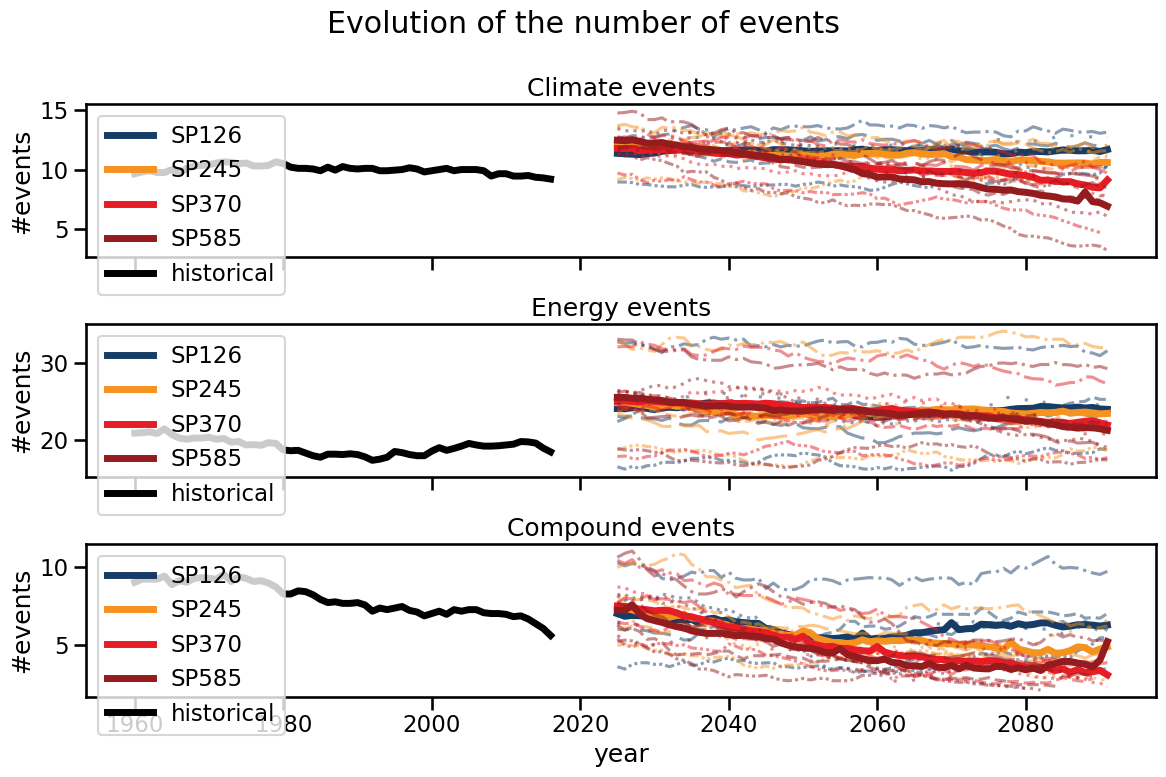

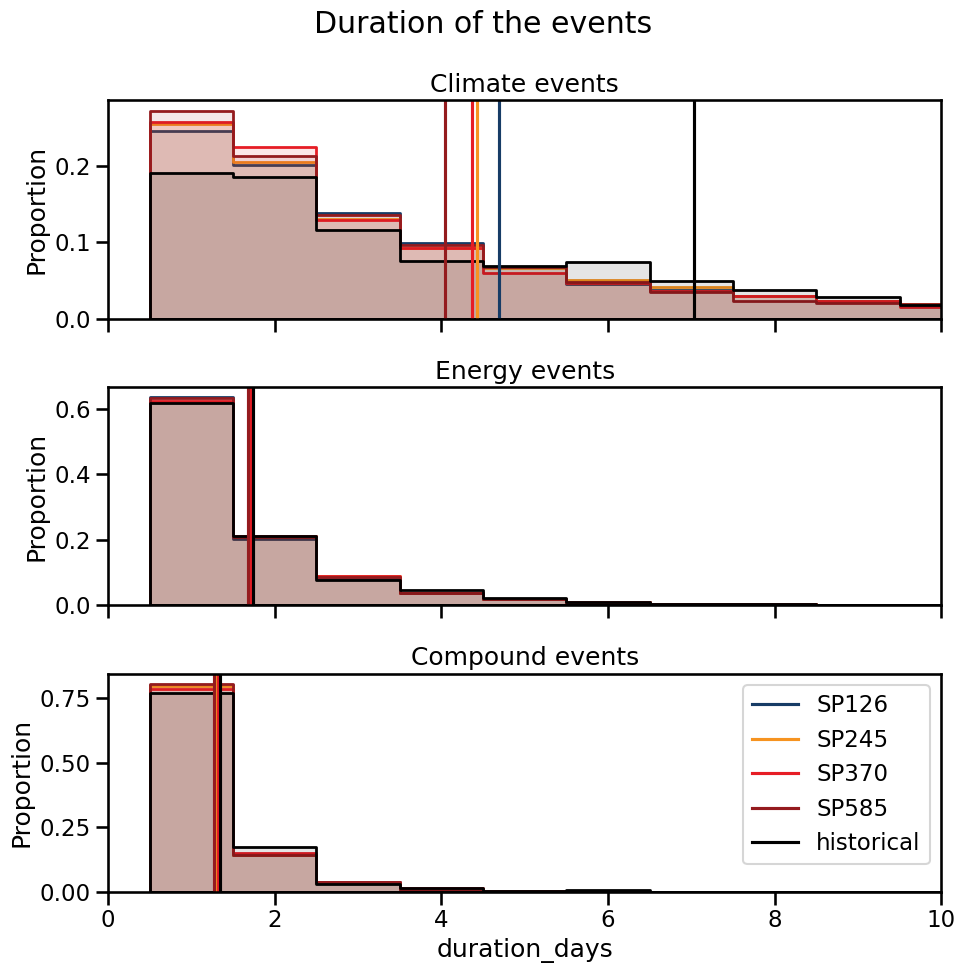

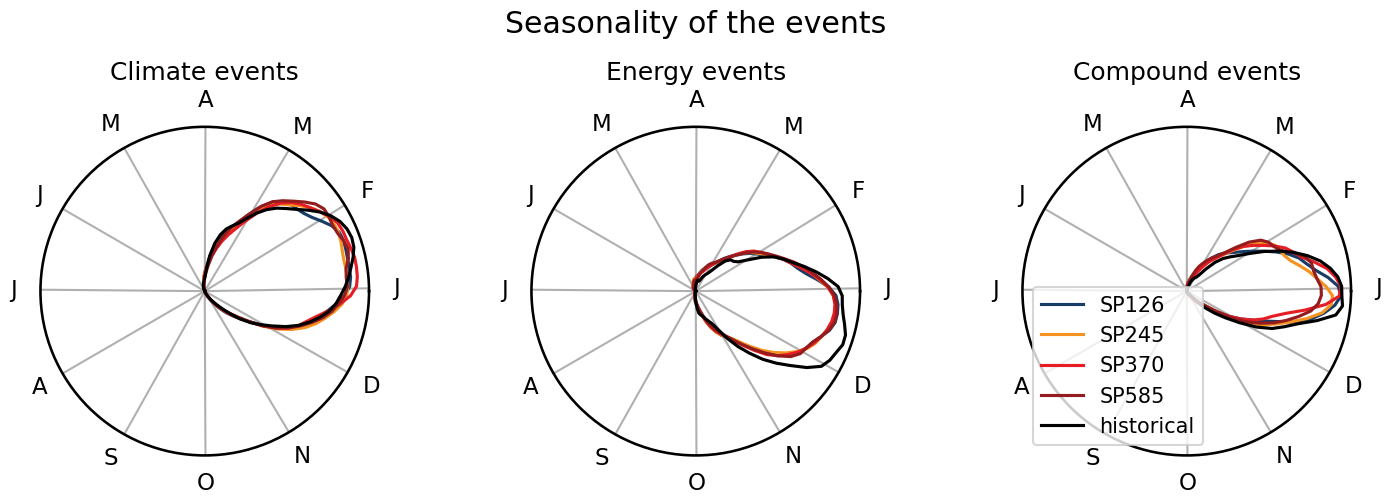

In [ ]:
from weavepy import *
from config import BDD_VERSION, MODEL_NAMES, CLIM_VARS, ENER_VARS, ENER_VARS_TECHNOS, COUNTRIES_LIST, SCENARIOS
sns.set_context("talk")
import ipywidgets as widgets
from IPython.display import display, clear_output

####################################################################################################################################################
################################################################## --- WIDGETS --- #################################################################
####################################################################################################################################################

##-------------------------##
## --- CLIMATE Widgets --- ##
##-------------------------##

wdg_climate_variable = widgets.Dropdown(
    options=CLIM_VARS,
    value="TA",
    description="Climate Variable:",
)

wdg_aggregation_frequency = widgets.Dropdown(
    options=["H", "D", "M", "Y"],
    value="D",
    description="Frequency:",
)

wdg_aggregation_function = widgets.Dropdown(
    options=["mean", "sum", "max", "min"],
    value="mean",
    description="Aggregation Function:",
)

##-------------------------##
## --- ENERGY  Widgets --- ##
##-------------------------##

wdg_energy_variable = widgets.Dropdown(
    options=ENER_VARS,
    value="SPV",
    description="Energy Variable:",
)

wdg_techno = widgets.Dropdown(
    options=ENER_VARS_TECHNOS[wdg_energy_variable.value],
    value="60",
    description="Technology:",
)

##-------------------------##
## --- EVENT DETECTION --- ##
##-------------------------##

wdg_climate_variable_comparison = widgets.RadioButtons(
    options=["<", "<=", ">", ">="],
    value="<=",
    description="Climate Operator:",
)

wdg_climate_variable_threshold = widgets.FloatSlider(
    min=-30, max=50, step=0.5, value=5,
    description="Climate Threshold:",
)

wdg_energy_variable_comparison = widgets.RadioButtons(
    options=["<", "<=", ">", ">="],
    value="<",
    description="Energy Operator:",
)

wdg_energy_variable_threshold = widgets.FloatSlider(
    min=0, max=1, step=0.05, value=0.05,
    description="Energy Threshold (capacity factor):",
)

##-------------------------##
## ---  TIME  PERIODS  --- ##
##-------------------------##

wdg_historical_period = widgets.IntRangeSlider(
    value=[1990, 2025],
    min=1950, max=2025, step=1,
    description="Historical period:",
)

wdg_future_period = widgets.IntRangeSlider(
    value=[2015, 2100],
    min=2015, max=2100, step=1,
    description="Future period:",
)

##-------------------------##
## -- COUNTRY SELECTION -- ##
##-------------------------##

wdg_country = widgets.Dropdown(
    options=COUNTRIES_LIST,
    value=COUNTRIES_LIST[0],
    description="Country:",
)

##-------------------------##
## -- MODELS  SELECTION -- ##
##-------------------------##

wdg_models = MODEL_NAMES

# Individual checkboxes
model_checkboxes = {name: widgets.Checkbox(value=True, description=name) for name in MODEL_NAMES}

# Select/Deselect All checkbox
chk_all_models = widgets.Checkbox(value=True, description="Select/Deselect All models", indent=False)

##-------------------------##
## - SCENARIOS SELECTION - ##
##-------------------------##

wdg_scenarios = SCENARIOS

# Individual checkboxes
scenarios_checkboxes = {name: widgets.Checkbox(value=True, description=name) for name in SCENARIOS}

# Select/Deselect All checkbox
chk_all_scenarios = widgets.Checkbox(value=True, description="Select/Deselect All scenarios", indent=False)

##-------------------------##
## -- EXECUTION WIDGETS -- ##
##-------------------------##

status_label = widgets.Label(value="Ready.")
execute_button = widgets.Button(description="Execute", button_style="success")

####################################################################################################################################################
################################################################# --- FUNCTIONS --- ################################################################
####################################################################################################################################################

##-------------------------##
## -- MODELS  SELECTION -- ##
##-------------------------##

def sync_models_checkboxes(change=None):
    """Update chk_all_models to reflect current state of model_checkboxes."""
    if all(chk.value for chk in model_checkboxes.values()):
        chk_all_models.unobserve(toggle_all_models, "value")  # prevent recursion
        chk_all_models.value = True
        chk_all_models.observe(toggle_all_models, "value")
    else:
        chk_all_models.unobserve(toggle_all_models, "value")
        chk_all_models.value = False
        chk_all_models.observe(toggle_all_models, "value")

def update_models_list(change=None):
    global wdg_models
    wdg_models = [name for name, chk in model_checkboxes.items() if chk.value]

def toggle_all_models(change):
    """Select/deselect all checkboxes when chk_all_models is toggled."""
    if change["new"] is True:
        for chk in model_checkboxes.values():
            chk.value = True
    elif change["new"] is False:
        for chk in model_checkboxes.values():
            chk.value = False

##-------------------------##
## - SCENARIOS SELECTION - ##
##-------------------------##

def sync_scenarios_checkboxes(change=None):
    """Update chk_all_scenarios to reflect current state of scenarios_checkboxes."""
    if all(chk.value for chk in scenarios_checkboxes.values()):
        chk_all_scenarios.unobserve(toggle_all_scenarios, "value")  # prevent recursion
        chk_all_scenarios.value = True
        chk_all_scenarios.observe(toggle_all_scenarios, "value")
    else:
        chk_all_scenarios.unobserve(toggle_all_scenarios, "value")
        chk_all_scenarios.value = False
        chk_all_scenarios.observe(toggle_all_scenarios, "value")

def update_scenarios_list(change=None):
    global wdg_scenarios
    wdg_scenarios = [name for name, chk in scenarios_checkboxes.items() if chk.value]

def toggle_all_scenarios(change):
    """Select/deselect all checkboxes when chk_all_scenarios is toggled."""
    if change["new"] is True:
        for chk in scenarios_checkboxes.values():
            chk.value = True
    elif change["new"] is False:
        for chk in scenarios_checkboxes.values():
            chk.value = False

##-------------------------##
## --- ENER VAR TECHNO --- ##
##-------------------------##

def update_techno(change):
    new_energy = change["new"]
    wdg_techno.options = ENER_VARS_TECHNOS[new_energy]
    wdg_techno.value = ENER_VARS_TECHNOS[new_energy][0]

##-------------------------##
##- SELECTION CHANGED MSG -##
##-------------------------##

def mark_dirty(change):
    global status_label
    status_label.value = "⚠️ Parameters changed. Click Execute to update."

####################################################################################################################################################
################################################################# --- OBSERVERS --- ################################################################
####################################################################################################################################################

##-------------------------##
## ---- BASIC WIDGETS ---- ##
##-------------------------##

for w in [
    wdg_climate_variable, wdg_aggregation_frequency, wdg_aggregation_function,
    wdg_energy_variable, wdg_techno, wdg_climate_variable_comparison, wdg_climate_variable_threshold,
    wdg_energy_variable_comparison, wdg_energy_variable_threshold, wdg_country,
    wdg_historical_period, wdg_future_period,
]:
    w.observe(mark_dirty, names="value")

##-------------------------##
## --- MODELS  WIDGETS --- ##
##-------------------------##

for chk in model_checkboxes.values():
    chk.observe(sync_models_checkboxes, "value")
    chk.observe(update_models_list, "value")
    chk.observe(mark_dirty, names="value")

chk_all_models.observe(toggle_all_models, "value")
chk_all_models.observe(mark_dirty, names="value")

##-------------------------##
## -- SCENARIOS WIDGETS -- ##
##-------------------------##

for chk in scenarios_checkboxes.values():
    chk.observe(sync_scenarios_checkboxes, "value")
    chk.observe(update_scenarios_list, "value")
    chk.observe(mark_dirty, names="value")

chk_all_scenarios.observe(toggle_all_scenarios, "value")
chk_all_scenarios.observe(mark_dirty, names="value")

##-------------------------##
## --- ENER VAR TECHNO --- ##
##-------------------------##

wdg_energy_variable.observe(update_techno, names="value")

####################################################################################################################################################
################################################################# --- EXECUTION --- ################################################################
####################################################################################################################################################

def on_execute_clicked(b):

    clear_output(wait=True)

    display(ui, status_label)

    status_label.value = "⏳ Running..."

    # Retrieve values from widgets
    climate_variable = wdg_climate_variable.value
    aggregation_frequency = wdg_aggregation_frequency.value
    aggregation_function = wdg_aggregation_function.value
    energy_variable = wdg_energy_variable.value
    techno = wdg_techno.value
    climate_variable_comparison = wdg_climate_variable_comparison.value
    climate_variable_threshold = wdg_climate_variable_threshold.value
    energy_variable_comparison = wdg_energy_variable_comparison.value
    energy_variable_threshold = wdg_energy_variable_threshold.value
    country = wdg_country.value
    historical_period = wdg_historical_period.value
    future_period = wdg_future_period.value
    models = wdg_models
    scenarios = wdg_scenarios
    
    # LOAD Data
    data = load_vars([climate_variable, energy_variable], bdd_version = BDD_VERSION,
              countries = [country], technos = ["NA", techno], models = models, scenarios = scenarios, 
              aggregation_frequency = aggregation_frequency, aggregation_function = aggregation_function,
              verbose=True)
    
    # Identify event days
    climate_days = identify_pb_days(data[climate_variable], climate_variable_comparison, climate_variable_threshold).rename("climate_event")
    energy_days = identify_pb_days(data[energy_variable], energy_variable_comparison, energy_variable_threshold).rename("energy_event")
    compound_days = (climate_days & energy_days).rename("compound_event")

    # Identify events
    climate_events = identify_events_whole_base(climate_days)
    energy_events = identify_events_whole_base(energy_days)
    compound_events = identify_events_whole_base(compound_days)

    # REDUCE TO SELECTED MODELS
    if not chk_all_models.value:
        climate_events = climate_events[climate_events['model'].isin(list(models))]
        energy_events = energy_events[energy_events['model'].isin(list(models))]
        compound_events = compound_events[compound_events['model'].isin(list(models))]
        climate_days = climate_days.sel(model=list(models))
        energy_days = energy_days.sel(model=list(models))
        compound_days = compound_days.sel(model=list(models))

    # REDUCE TO SELECTED SCENARIOS
    if not chk_all_scenarios.value:
        climate_events = climate_events[climate_events['scenario'].isin(list(scenarios))]
        energy_events = energy_events[energy_events['scenario'].isin(list(scenarios))]
        compound_events = compound_events[compound_events['scenario'].isin(list(scenarios))]
        climate_days = climate_days.sel(scenario=list(scenarios))
        energy_days = energy_days.sel(scenario=list(scenarios))
        compound_days = compound_days.sel(scenario=list(scenarios))

    # Count number of events
    N_climate_events = climate_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()
    N_energy_events = energy_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()
    N_compound_events = compound_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()

    # Plotting
    nb_event_timeseries(N_climate_events, N_energy_events, N_compound_events)
    event_duration_hist(climate_events, energy_events, compound_events)
    event_seasonality_kde(climate_days, energy_days, compound_days)

    #Update status label
    status_label.value = "✅ Done!"

execute_button.on_click(on_execute_clicked)

####################################################################################################################################################
################################################################## --- LAYOUT --- ##################################################################
####################################################################################################################################################

ui = widgets.VBox([
        widgets.HBox([
            widgets.VBox([wdg_climate_variable],
                         #layout=widgets.Layout(justify_content="space-between", align_items="center", border="2px solid #888", padding="5px")
                         ),
            widgets.VBox([wdg_energy_variable, wdg_techno],
                         #layout=widgets.Layout(justify_content="space-between", align_items="center", border="2px solid #888", padding="5px")
                         ),],
            #layout=widgets.Layout(align_items="center", border="2px solid #888", padding="5px")
            ),
        widgets.VBox([
            widgets.HBox([wdg_aggregation_frequency, wdg_aggregation_function]),
            widgets.HBox([wdg_country]),
        ],#layout=widgets.Layout(justify_content="space-between", align_items="center", border="2px solid #888", padding="5px")
                     ),
    widgets.HBox([wdg_historical_period, wdg_future_period]),
    widgets.HBox([wdg_climate_variable_comparison, wdg_climate_variable_threshold]),
    widgets.HBox([wdg_energy_variable_comparison, wdg_energy_variable_threshold]),
    
    widgets.HBox([
        widgets.VBox([chk_all_models] + list(model_checkboxes.values())),
        widgets.VBox([chk_all_scenarios] + list(scenarios_checkboxes.values())),]),
    #widgets.HBox([wdg_models, wdg_scenarios,btn_reset]),
    execute_button
])

display(ui, status_label)
